In [10]:
pip install biosppy

In [0]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import itertools
import collections
import glob
import pywt
import math
import biosppy
import pandas as pd
from scipy import signal
from keras.utils import to_categorical

%matplotlib inline

# Plot Setting

In [0]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

# Functions

In [0]:
# Train Inputs
def get_train_inputs():
    x = tf.constant(X_train)
    y = tf.constant(y_train)
    return x, y

# Test Inputs
def get_test_inputs():
    x = tf.constant(X_test)
    y = tf.constant(y_test)
    return x, y

# Eval data
def get_eval_data():
    return tf.constant(X_test)

# Plot matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #cm[i, j] = 0 if np.isnan(cm[i, j]) else cm[i, j]
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Comment

### Arrhythmia Type List
- Normal = 'N', 'L', 'R', 'e', 'j'
- SVEB = 'A', 'a', 'J', 'S'
- VEB = 'V', 'E'
- F = 'F'
- Q = '/', 'f'

### Arrhythmia Annotation
- N = Normal beat
- L = Left bundle branch block beat
- R = Right bundle branch block beat
- e = Atrial escape beat
- j = Nodal (junctional) escape beat
- A = Atrial premature beat
- a = Aberrated atrial premature beat
- J = Nodal (junctional) premature beat
- S = Supraventricular premature or ectopic beat (atrial or nodal)
- V = Premature ventricular contraction
- E = Ventricular escape beat
- F = Fusion of ventricular and normal beat
- / = Paced beat
- f = Fusion of paced and normal beat

### The Number of Each Arrhythmia Type
- #### N = 10001
- #### L = 8075
- #### R = 7259
- e = 16
- j = 229
- #### A = 2546
- a = 150
- J = 83
- S = 2
- #### V = 7130
- E = 106
- F = 803
- #### / = 7028
- f = 982

# Read Dataset

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Variables

path = "gdrive/My Drive/Graduate/Courses/EE8610/mitDB/"
window_size = 160
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V', '/']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

# Data Processing

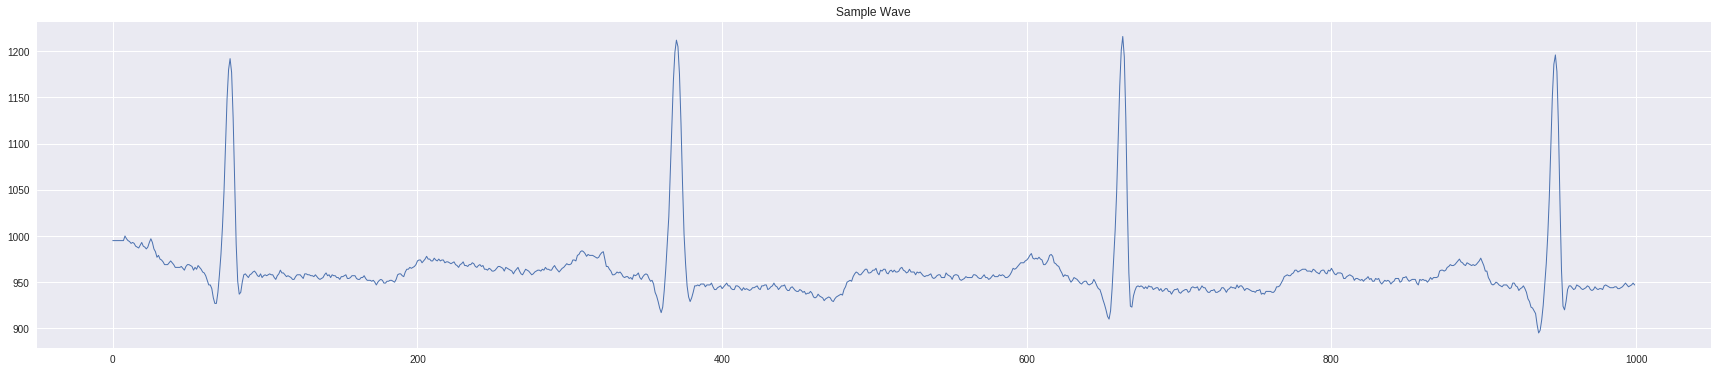

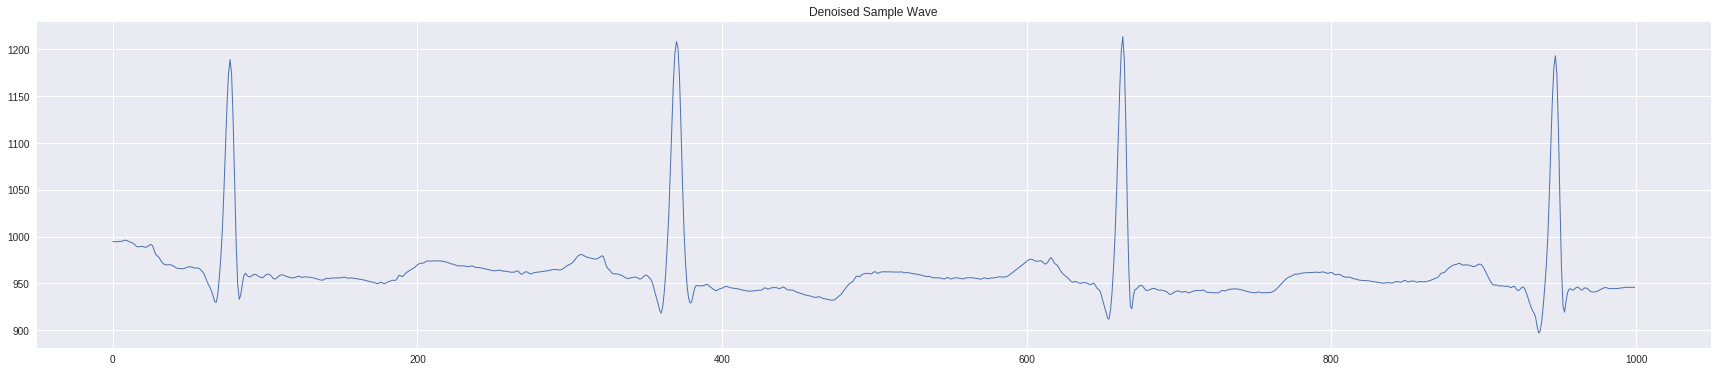

In [16]:
# Read files
# paths = glob.glob('gdrive/My Drive/Graduate/Courses/EE8610/mitDB/*.csv')
filenames = next(os.walk(path))[2]

filenames.sort()

# Split and save .csv , .txt 
records = list()
annotations = list()

for f in filenames:
    filename, file_extension = os.path.splitext(f)
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)  
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1  
    
    
    
    ###### DWT w/ thresholding #####
    w = pywt.Wavelet('coif5')
    nl = 6
    coeffs = pywt.wavedec(signals, w, level=nl)
    
    # Apply the threshold.  Pseudocode here.
    new_coeffs = []
    for nc in coeffs:
      threshVal = (np.std(signals)/75)*(math.sqrt(2*math.log(len(signals))))
      tcoeff = pywt.threshold(nc, threshVal , mode='soft')
      new_coeffs.append(tcoeff)
    
    # IDWT
    renc = pywt.waverec(new_coeffs, w);  
        
    if r is 0:
        # Plot first patient's signal
  #         plt.subplot(2,1,1)
        plt.title("Sample Wave")
        plt.plot(signals[:1000])
        plt.show()

  #         plt.subplot(2,1,2)
        plt.title("Denoised Sample Wave")
        plt.plot(renc[:1000])
        plt.show()

    # Read anotations: R position and Arrhythmia class
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type

            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                    pass
                else:
                    count_classes[arrhythmia_index] += 1
                    if(window_size < pos and pos < (len(renc) - window_size)):
                        beat = signal.resample(renc[pos-window_size+1:pos+window_size],130)
                        X.append(beat)
                        y.append(arrhythmia_index)

# Training & Test

In [17]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

print("X_train : ", len(X_train))
print("X_test  : ", len(X_test))
print("y_train : ", collections.Counter(y_train))
print("y_test  : ", collections.Counter(y_test))


X_train :  28154
X_test  :  13867
y_train :  Counter({0: 6653, 1: 5434, 2: 4904, 5: 4721, 4: 4720, 3: 1722})
y_test  :  Counter({0: 3344, 1: 2637, 4: 2409, 2: 2351, 5: 2302, 3: 824})


In [18]:
print(np.shape(X_train[0]))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(130,)
(28154,)
(13867, 130)
(13867,)


In [19]:
model_m = tf.keras.models.Sequential()
model_m.add(tf.keras.layers.Conv1D(18, 7, activation='sigmoid', input_shape=(130, 1)))
model_m.add(tf.keras.layers.MaxPooling1D(2))
model_m.add(tf.keras.layers.Conv1D(18, 7, activation='sigmoid'))
model_m.add(tf.keras.layers.MaxPooling1D(2))

model_m.add(tf.keras.layers.GlobalAveragePooling1D())
model_m.add(tf.keras.layers.Dropout(0.5))
model_m.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

print(model_m.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 124, 18)           144       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 62, 18)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 56, 18)            2286      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 28, 18)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 18)                0         
_________________________________________________________________
dropout (Dropout)    

In [20]:
model_m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

BATCH_SIZE = 100
EPOCHS = 50

X_train = np.expand_dims(X_train, axis=2)
# X_train = np.reshape(X_train, (np.shape(X_train)[0], np.shape(X_train)[1], 1))
y_binary = to_categorical(y_train,num_classes=n_classes)

display(np.shape(X_train))
history = model_m.fit(X_train,y_binary)

(28154, 130, 1)

Instructions for updating:
Use tf.cast instead.
28154/28154 [==============================] - 10s 346us/sample - loss: 1.7503 - acc: 0.2207


In [21]:
print(history.history.keys())
print(history.history['loss'])
print(history.history['acc'])
print(history.history['val_loss'])
print(history.history['val_acc'])

dict_keys(['loss', 'acc'])
[1.7503416190781174]
[0.22071464]


KeyError: ignored

In [0]:
X_test = np.reshape(X_test, (np.shape(X_test)[0], np.shape(X_test)[1], 1))


# accuracy_score = model_m.evaluate(X_test,y_test,batch_size=10)[1]
predictions = model_m.predict(X_test)
display(predictions)



```

# Results

In [0]:
    
cm = confusion_matrix(y_test, predictions.argmax(axis=1))

print("\nTest Accuracy: {0:f}%\n".format(accuracy_score*100))
plot_confusion_matrix(cm, classes, normalize=True)